In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import pandas as pd
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
from torchvision import transforms
#import pretrainedmodels
import math
import sys
import pickle
#from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'


In [2]:
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image

class customDataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []
        self.labels_mapping = {}  # Từ điển để ánh xạ nhãn chuỗi sang số nguyên

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name, item_id và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            item_id = parts[1]
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = train
            if evaluation_status == "train" and image_name in self.image_paths:
                # Thêm nhãn vào từ điển ánh xạ nếu chưa có
                if item_id not in self.labels_mapping:
                    self.labels_mapping[item_id] = len(self.labels_mapping)
                label_index = self.labels_mapping[item_id]  # Chỉ số nhãn
                self.data.append((label_index, self.image_paths[image_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None  # Skip this sample if there's an error
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [4]:
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

train_dataset = customDataset(ROOT_DIR, CSV_PATH, transform = transform)

In [5]:
print(f"Tổng số mẫu trong dataset: {len(train_dataset)}")


Tổng số mẫu trong dataset: 25882


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

# Cấu hình các tham số
BS = 48
NUM_WORKERS = 16

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=NUM_WORKERS)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


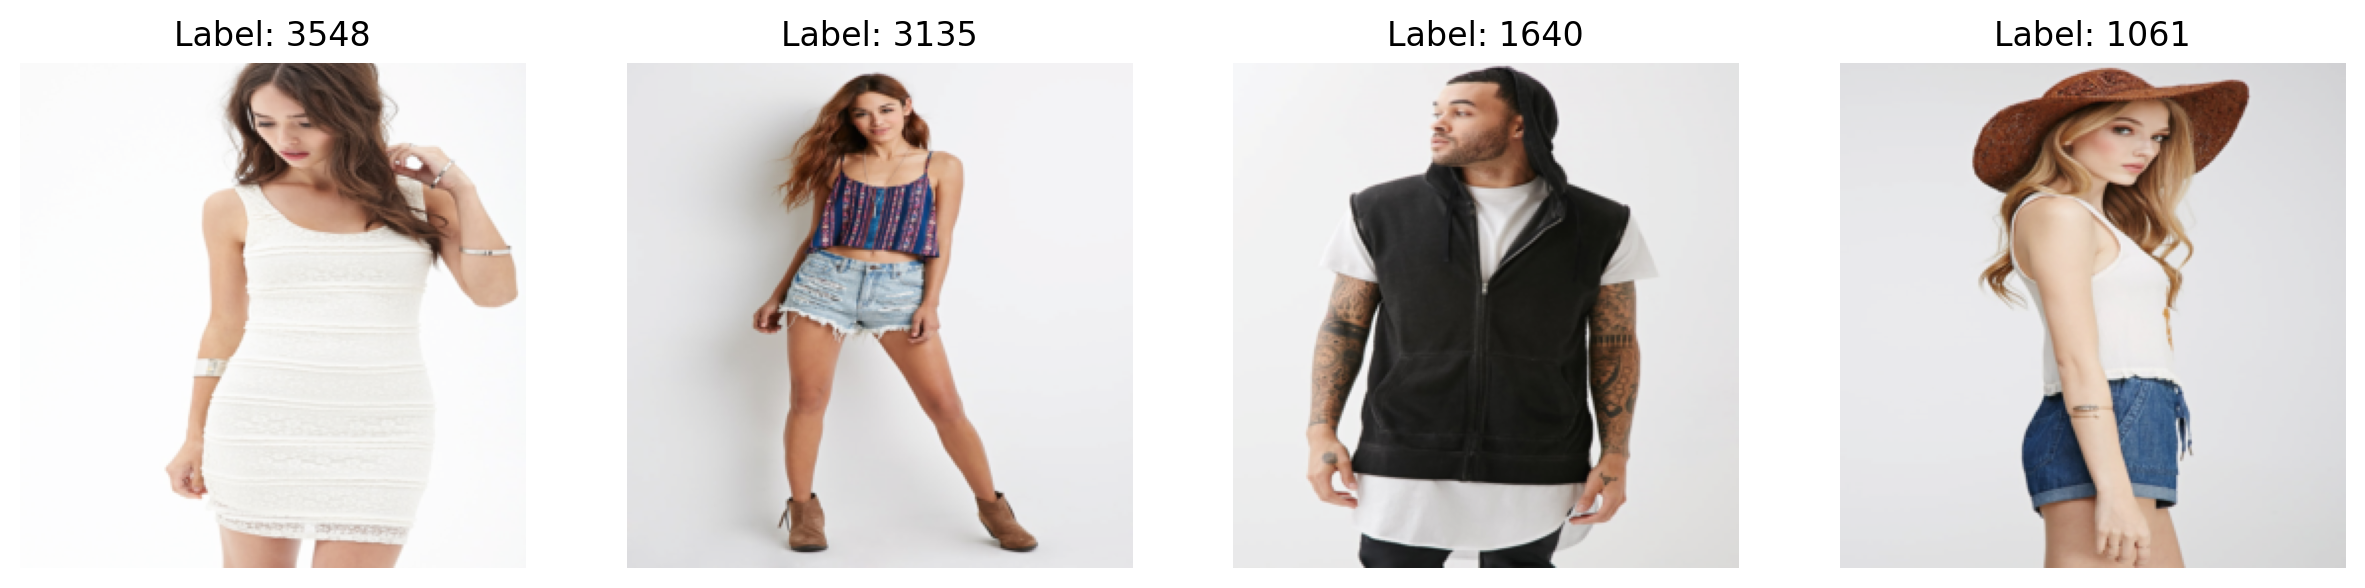

In [7]:
# Kiểm tra một batch dữ liệu
import matplotlib.pyplot as plt

# Kiểm tra một batch dữ liệu
def show_batch(data_loader, n=4):
    images, labels = next(iter(data_loader))  # Lấy một batch
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # Chuyển tensor về numpy
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Undo Normalize
        img = img.clip(0, 1)  # Giới hạn giá trị pixel từ 0 đến 1
        axes[i].imshow(img)
        axes[i].axis('off')
        # Hiển thị label dưới ảnh
        axes[i].set_title(f"Label: {labels[i]}")
    plt.show()

show_batch(train_loader)

In [8]:
# Lấy tất cả các nhãn từ dataset
all_labels = [label for _, label in train_dataset]

# Lấy số lượng lớp (số lượng nhãn duy nhất)
NUM_CLASSES = len(set(all_labels))  # Dùng set để loại bỏ nhãn trùng lặp
print(f"Số lượng lớp: {NUM_CLASSES}")


Số lượng lớp: 3997


In [9]:
from torchvision import models

arch = models.resnet152
model_name = f'{arch.__name__}'
print(model_name)  # Kết quả: resnet152


resnet152


In [10]:
# arch = models.resnet101
# model_name = f'{arch.__name__}'

In [11]:
# arch = models.resnet50
# model_name = f'{arch.__name__}'

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
from torchvision.models import ResNet152_Weights
archcut = nn.Sequential(
    *list(arch(weights=ResNet152_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
model = archcut.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:03<00:00, 80.3MB/s] 


In [14]:
# from torchvision.models import ResNet101_Weights
# archcut = nn.Sequential(
#     *list(arch(weights=ResNet101_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
# model = archcut.to(device)

In [15]:
# from torchvision.models import ResNet50_Weights
# archcut = nn.Sequential(
#     *list(arch(weights=ResNet50_Weights.DEFAULT).children())[:-2], nn.AdaptiveAvgPool2d(1),nn.Flatten(), nn.Linear(2048, NUM_CLASSES))
# model = archcut.to(device)

In [16]:
def validate_model(model, val_loader, criterion, device):
    """
    Đánh giá mô hình trên tập validation.

    Args:
        model: Mô hình PyTorch.
        val_loader: DataLoader cho tập validation.
        criterion: Hàm loss (vd: nn.CrossEntropyLoss).
        device: Thiết bị (cuda hoặc cpu).

    Returns:
        val_loss: Giá trị loss trung bình trên tập validation.
        accuracy: Độ chính xác trung bình trên tập validation.
    """
    model.eval()  # Đặt chế độ đánh giá
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Tính toán độ chính xác
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy

In [17]:
from tqdm import tqdm

def train_model_with_eval(model, train_loader, val_loader, criterion, optimizer, device, epochs, mixup_alpha=0.4):
    """
    Huấn luyện mô hình PyTorch với Mixup và FP16, đồng thời đánh giá trên tập validation sau mỗi epoch,
    và sử dụng TQDM để theo dõi tiến trình huấn luyện và validation.

    Args:
        model: Mô hình PyTorch.
        train_loader: DataLoader cho tập huấn luyện.
        val_loader: DataLoader cho tập validation.
        criterion: Hàm loss (vd: nn.CrossEntropyLoss).
        optimizer: Optimizer (vd: Adam).
        device: Thiết bị (cuda hoặc cpu).
        epochs: Số lượng epoch huấn luyện.
        mixup_alpha: Tham số alpha cho Mixup augmentation.

    Returns:
        model: Mô hình đã được huấn luyện.
        train_losses: Loss trên tập huấn luyện cho mỗi epoch.
        val_losses: Loss trên tập validation cho mỗi epoch.
        val_accuracies: Độ chính xác trên tập validation cho mỗi epoch.
    """
    # Mixup function
    def mixup_data(images, labels, alpha):
        lam = torch.distributions.Beta(alpha, alpha).sample().item()
        index = torch.randperm(images.size(0)).to(device)
        mixed_images = lam * images + (1 - lam) * images[index, :]
        labels_a, labels_b = labels, labels[index]
        return mixed_images, labels_a, labels_b, lam
    
    # FP16 GradScaler
    scaler = GradScaler()
    
    # Chuyển mô hình sang device
    model.to(device)
    
    # Biến lưu loss và accuracy
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        print(f"Epoch {epoch+1}/{epochs} - Training...")
        
        # Huấn luyện trên tập train với TQDM
        train_bar = tqdm(train_loader, desc="Training", ncols=100)
        for batch_idx, (images, labels) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device)

            # Áp dụng Mixup
            mixed_images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
            
            # Huấn luyện với FP16
            optimizer.zero_grad()
            with autocast():
                outputs = model(mixed_images)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            
            # Backpropagation và cập nhật trọng số
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

            # Cập nhật tiến độ TQDM
            train_bar.set_postfix(loss=loss.item())

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Đánh giá trên tập validation với TQDM
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc="Validation", ncols=100)
        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Cập nhật tiến độ TQDM
                val_bar.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
        
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_accuracy = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_train_loss:.4f} - Validation Loss: {epoch_val_loss:.4f} - Validation Accuracy: {epoch_val_accuracy:.2f}%")
    
    return model, train_losses, val_losses, val_accuracies


In [18]:
import torch.optim as optim
import torch
from torch.utils.data import random_split, DataLoader
from torch.cuda.amp import GradScaler, autocast
# Hyperparameters
EPOCHS = 15
LR = 1e-3
MIXUP_ALPHA = 0.4

# Loss function và Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Chia dữ liệu thành 80% huấn luyện và 20% validation
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% cho training
val_size = total_size - train_size  # 20% cho validation

# Sử dụng random_split để chia dataset
train_data, val_dataset = random_split(train_dataset, [train_size, val_size])

# Tạo DataLoader cho tập huấn luyện và validation
train_loader = DataLoader(train_data, batch_size=BS, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=NUM_WORKERS)

# Huấn luyện mô hình với validation
trained_model, train_losses, val_losses, val_accuracies = train_model_with_eval(model, train_loader, val_loader, criterion, optimizer, device, EPOCHS, MIXUP_ALPHA)



/tmp/ipykernel_23/52764111.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/15 - Training...


Training:   0%|                                                             | 0/432 [00:00<?, ?it/s]/tmp/ipykernel_23/52764111.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.84it/s, accuracy=1.18, loss=7.78]


Epoch [1/15] - Train Loss: 8.0230 - Validation Loss: 7.6772 - Validation Accuracy: 1.18%
Epoch 2/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.85it/s, accuracy=5.74, loss=6.77]


Epoch [2/15] - Train Loss: 6.9816 - Validation Loss: 6.4261 - Validation Accuracy: 5.74%
Epoch 3/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.85it/s, accuracy=14.3, loss=5.29]


Epoch [3/15] - Train Loss: 5.5864 - Validation Loss: 5.0543 - Validation Accuracy: 14.29%
Epoch 4/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.86it/s, accuracy=31.1, loss=3.97]


Epoch [4/15] - Train Loss: 4.3551 - Validation Loss: 3.5965 - Validation Accuracy: 31.14%
Epoch 5/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.86it/s, accuracy=44.9, loss=2.94]


Epoch [5/15] - Train Loss: 3.2691 - Validation Loss: 2.7657 - Validation Accuracy: 44.91%
Epoch 6/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.87it/s, accuracy=54.2, loss=2.34]


Epoch [6/15] - Train Loss: 2.8263 - Validation Loss: 2.3862 - Validation Accuracy: 54.20%
Epoch 7/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.85it/s, accuracy=53.5, loss=2.42]


Epoch [7/15] - Train Loss: 2.3775 - Validation Loss: 2.4120 - Validation Accuracy: 53.54%
Epoch 8/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.86it/s, accuracy=58.7, loss=2.26]


Epoch [8/15] - Train Loss: 2.1433 - Validation Loss: 2.1243 - Validation Accuracy: 58.66%
Epoch 9/15 - Training...


Validation: 100%|█████████████████████████| 108/108 [00:58<00:00,  1.85it/s, accuracy=52, loss=2.43]


Epoch [9/15] - Train Loss: 1.9009 - Validation Loss: 2.5913 - Validation Accuracy: 52.02%
Epoch 10/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.86it/s, accuracy=61.4, loss=1.98]


Epoch [10/15] - Train Loss: 1.8145 - Validation Loss: 2.0050 - Validation Accuracy: 61.41%
Epoch 11/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.87it/s, accuracy=64.3, loss=1.51]


Epoch [11/15] - Train Loss: 1.7763 - Validation Loss: 1.9609 - Validation Accuracy: 64.27%
Epoch 12/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.86it/s, accuracy=65.7, loss=1.41]


Epoch [12/15] - Train Loss: 1.7462 - Validation Loss: 1.8390 - Validation Accuracy: 65.71%
Epoch 13/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.87it/s, accuracy=64.1, loss=1.67]


Epoch [13/15] - Train Loss: 1.6142 - Validation Loss: 1.9193 - Validation Accuracy: 64.13%
Epoch 14/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:58<00:00,  1.86it/s, accuracy=57.6, loss=1.87]


Epoch [14/15] - Train Loss: 1.4544 - Validation Loss: 2.3462 - Validation Accuracy: 57.62%
Epoch 15/15 - Training...


Validation: 100%|███████████████████████| 108/108 [00:57<00:00,  1.86it/s, accuracy=45.2, loss=2.66]

Epoch [15/15] - Train Loss: 1.4304 - Validation Loss: 3.0650 - Validation Accuracy: 45.16%


In [19]:
# Lưu mô hình đã huấn luyện
torch.save(model.state_dict(), '/kaggle/working/extractorResnet152.pth')

In [20]:
previous_model_name

NameError: name 'previous_model_name' is not defined